# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import scanpy as sc
import anndata
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings
warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 2.36 s, sys: 351 ms, total: 2.71 s
Wall time: 2.75 s


In [5]:
%%time
rsc.utils.anndata_to_GPU(adata)

CPU times: user 1.5 s, sys: 741 ms, total: 2.24 s
Wall time: 2.24 s


In [6]:
adata.shape

(93575, 33694)

Verify the shape of the resulting sparse matrix:

In [7]:
adata.shape

(93575, 33694)

In [8]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 5.06316351890564


## Preprocessing

In [9]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [10]:
%%time
rsc.pp.flag_gene_family(adata,gene_family_name="MT", gene_family_prefix="MT-")

CPU times: user 6.47 ms, sys: 379 µs, total: 6.85 ms
Wall time: 6.69 ms


In [11]:
%%time
rsc.pp.flag_gene_family(adata,gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 5.39 ms, sys: 311 µs, total: 5.7 ms
Wall time: 5.53 ms


In [12]:
%%time
rsc.pp.calculate_qc_metrics(adata,qc_vars=["MT","RIBO"])

CPU times: user 89.1 ms, sys: 8.48 ms, total: 97.6 ms
Wall time: 166 ms


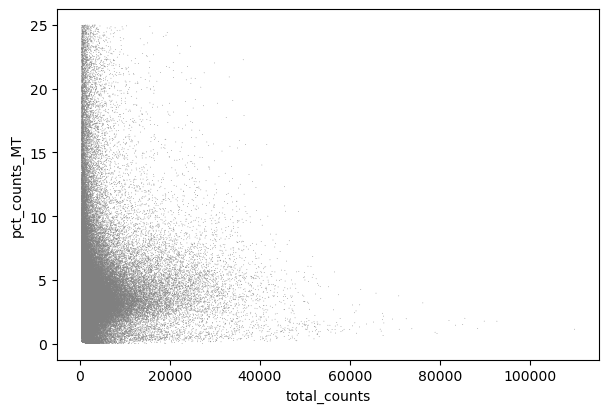

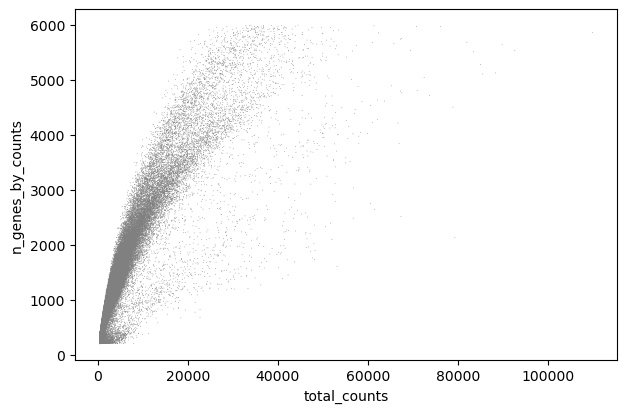

In [13]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

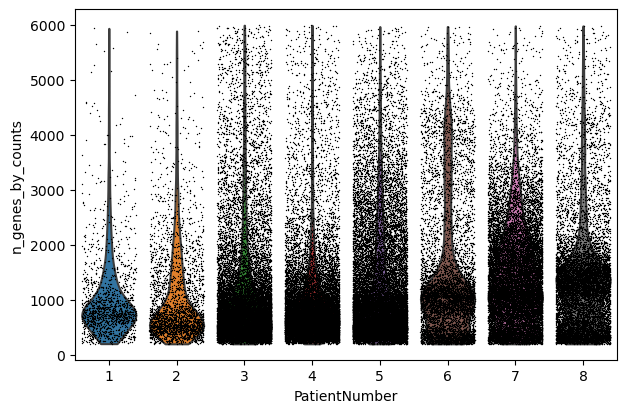

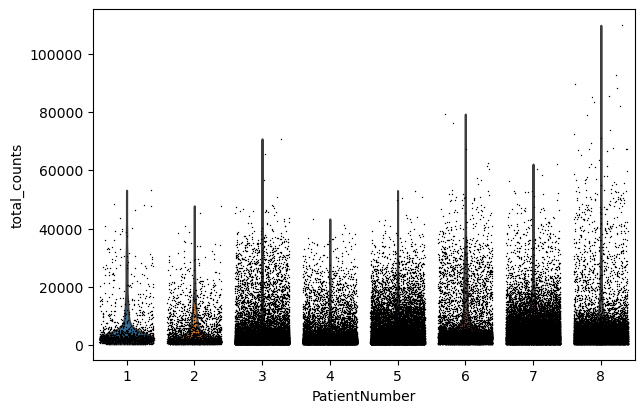

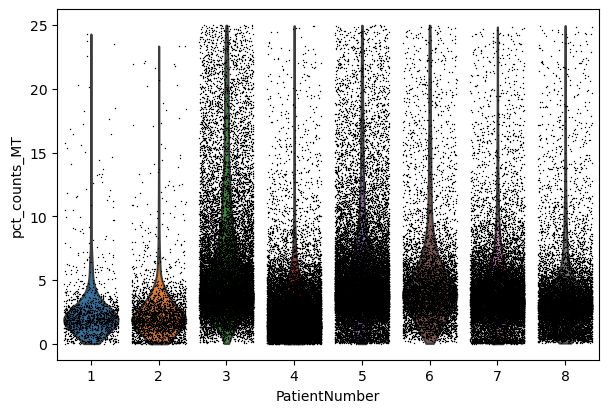

In [14]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'total_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'pct_counts_MT',jitter=0.4, groupby="PatientNumber")


### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [15]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] > 200]
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata.shape

CPU times: user 17.8 ms, sys: 6.75 ms, total: 24.6 ms
Wall time: 23.9 ms


(92666, 33694)

In [16]:
%%time
adata = adata[adata.obs["pct_counts_MT"] < 20]
adata.shape

CPU times: user 8.87 ms, sys: 1.75 ms, total: 10.6 ms
Wall time: 10 ms


(91180, 33694)

We also filter out genes that are expressed in less than 3 cells.

In [17]:
%%time
rsc.pp.filter_genes(adata,min_count=3)

filtered out 8034 genes based on n_cells_by_counts
CPU times: user 151 ms, sys: 69.3 ms, total: 220 ms
Wall time: 270 ms


We store the raw expression counts in the `.layer["counts"]`

In [18]:
adata.layers["counts"] = adata.X.copy()

In [19]:
adata.shape

(91180, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [20]:
%%time
rsc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 1.04 ms, sys: 160 µs, total: 1.2 ms
Wall time: 6.69 ms


Next, we log transform the count matrix.

In [21]:
%%time
rsc.pp.log1p(adata)

CPU times: user 62 µs, sys: 2.17 ms, total: 2.23 ms
Wall time: 2.09 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [22]:
%%time
rsc.pp.highly_variable_genes(adata,n_top_genes=5000,flavor="seurat_v3",batch_key= "PatientNumber",layer = "counts")

CPU times: user 1.08 s, sys: 2.95 s, total: 4.03 s
Wall time: 610 ms


Now we safe this verion of the AnnData as adata.raw.

In [23]:
%%time
adata.raw = adata

CPU times: user 83.6 ms, sys: 51.2 ms, total: 135 ms
Wall time: 134 ms


Now we restrict our AnnData object to the highly variable genes.

In [24]:
%%time
adata = adata[:,adata.var["highly_variable"]==True]

CPU times: user 62.8 ms, sys: 48 ms, total: 111 ms
Wall time: 111 ms


In [25]:
adata.shape

(91180, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [26]:
%%time
rsc.pp.regress_out(adata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 1.11 s, sys: 1.02 s, total: 2.13 s
Wall time: 2.16 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [27]:
%%time
rsc.pp.scale(adata,max_value=10)

CPU times: user 105 ms, sys: 4.25 ms, total: 109 ms
Wall time: 120 ms


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from cuMLs.

In [28]:
%%time
rsc.pp.pca(adata, n_comps = 100)

CPU times: user 680 ms, sys: 91.3 ms, total: 771 ms
Wall time: 780 ms


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

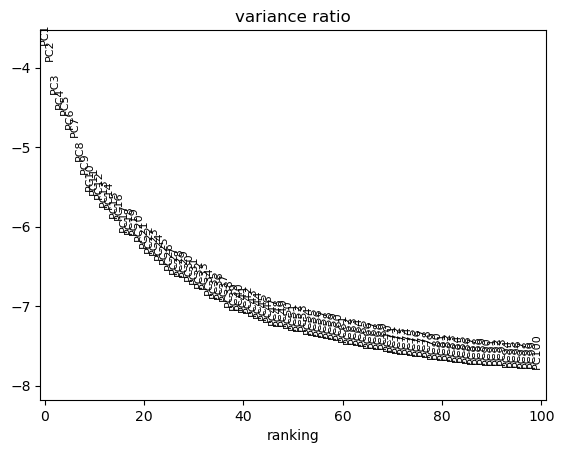

In [29]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

Now we move `.X` and `.layers` out of the GPU.

In [30]:
%%time
rsc.utils.anndata_to_CPU(adata, convert_all=True)

CPU times: user 189 ms, sys: 132 ms, total: 321 ms
Wall time: 320 ms


In [31]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 7.409643173217773


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [32]:
%%time
rsc.pp.harmony_integrate(adata,key="PatientNumber")

2023-08-28 16:04:15,276 - harmonypy_gpu - INFO - Iteration 1 of 10
2023-08-28 16:04:17,989 - harmonypy_gpu - INFO - Iteration 2 of 10
2023-08-28 16:04:20,668 - harmonypy_gpu - INFO - Iteration 3 of 10
2023-08-28 16:04:23,348 - harmonypy_gpu - INFO - Iteration 4 of 10
2023-08-28 16:04:26,035 - harmonypy_gpu - INFO - Iteration 5 of 10
2023-08-28 16:04:27,748 - harmonypy_gpu - INFO - Iteration 6 of 10
2023-08-28 16:04:30,434 - harmonypy_gpu - INFO - Iteration 7 of 10
2023-08-28 16:04:31,931 - harmonypy_gpu - INFO - Iteration 8 of 10
2023-08-28 16:04:33,863 - harmonypy_gpu - INFO - Iteration 9 of 10
2023-08-28 16:04:35,255 - harmonypy_gpu - INFO - Iteration 10 of 10
2023-08-28 16:04:37,082 - harmonypy_gpu - INFO - Converged after 10 iterations


CPU times: user 9.38 s, sys: 12.5 s, total: 21.9 s
Wall time: 22 s


In [33]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 246 ms, sys: 25.4 ms, total: 271 ms
Wall time: 279 ms


Next we calculate the UMAP embedding using rapdis.

In [34]:
%%time
rsc.tl.umap(adata)

CPU times: user 384 ms, sys: 9.04 ms, total: 393 ms
Wall time: 392 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [35]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 242 ms, sys: 321 ms, total: 562 ms
Wall time: 564 ms


In [36]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 224 ms, sys: 323 ms, total: 546 ms
Wall time: 547 ms


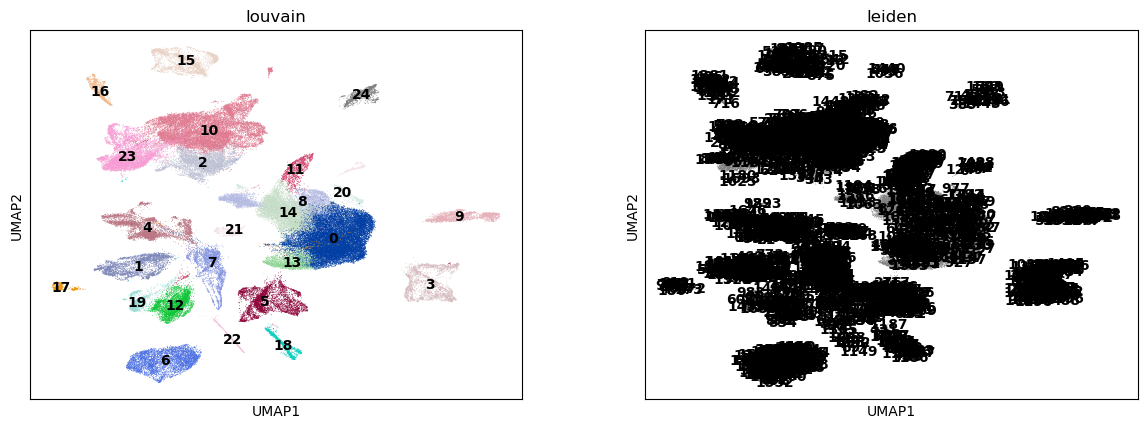

CPU times: user 1.91 s, sys: 196 ms, total: 2.11 s
Wall time: 1.94 s


In [37]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

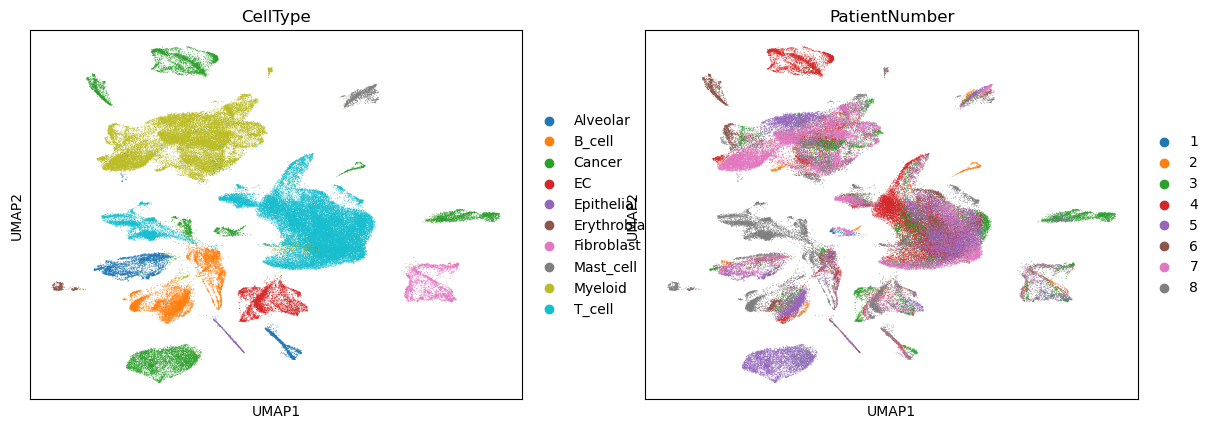

In [38]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

We also caluclate the embedding density in the UMAP using cuML

In [39]:
%%time
rsc.tl.embedding_density(adata, groupby="PatientNumber")

CPU times: user 569 ms, sys: 64.2 ms, total: 633 ms
Wall time: 677 ms


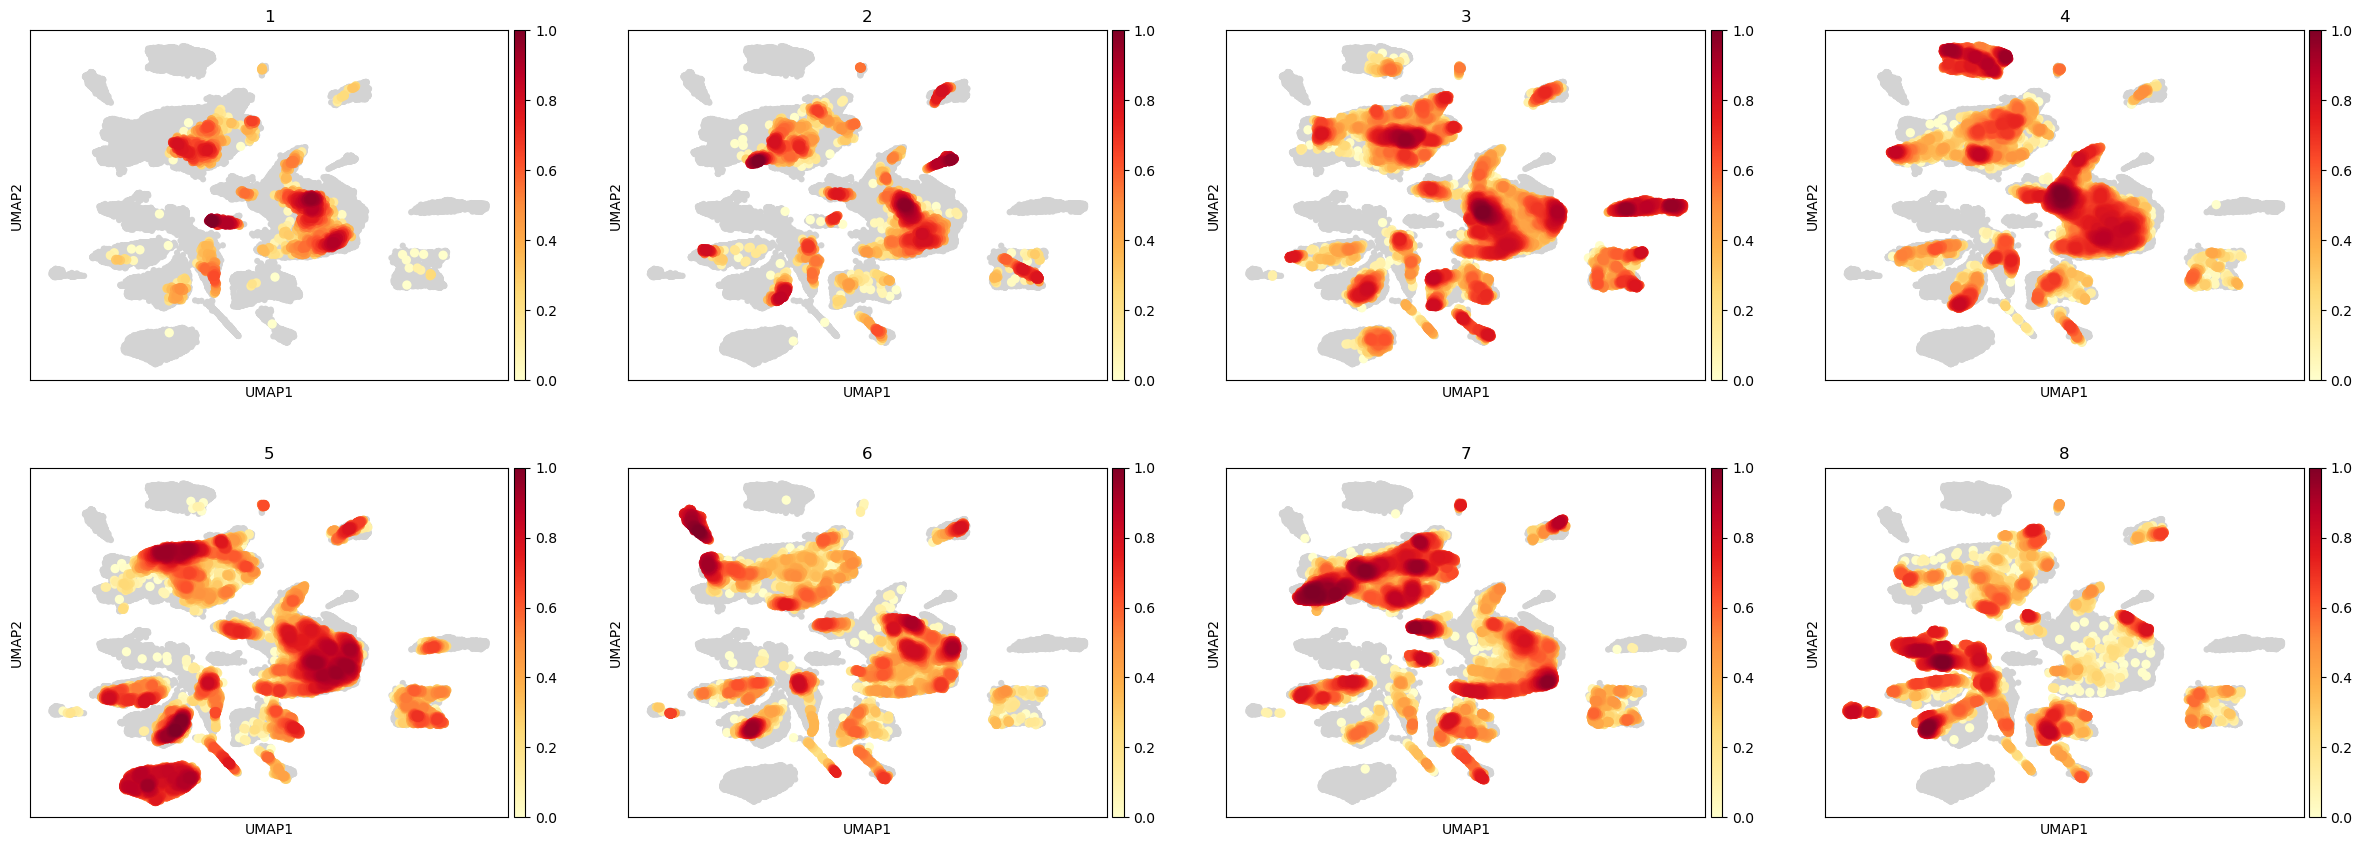

In [40]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [41]:
%%time
rsc.tl.tsne(adata, n_pcs = 40)

[W] [16:04:44.956091] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.28 s, sys: 1.36 s, total: 2.63 s
Wall time: 2.63 s


In [42]:
rsc.tl.kmeans(adata, n_clusters=8)

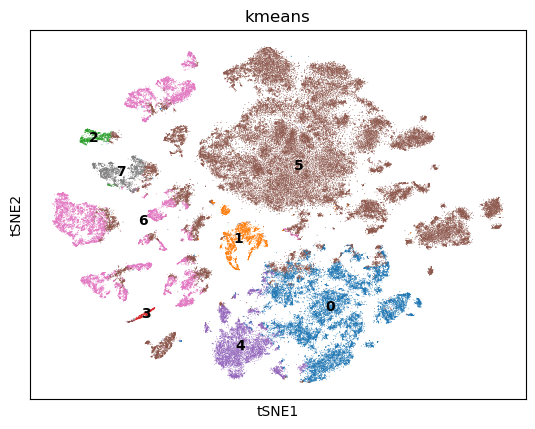

CPU times: user 355 ms, sys: 188 ms, total: 542 ms
Wall time: 324 ms


In [43]:
%%time
sc.pl.tsne(adata, color=["kmeans"],legend_loc = 'on data')

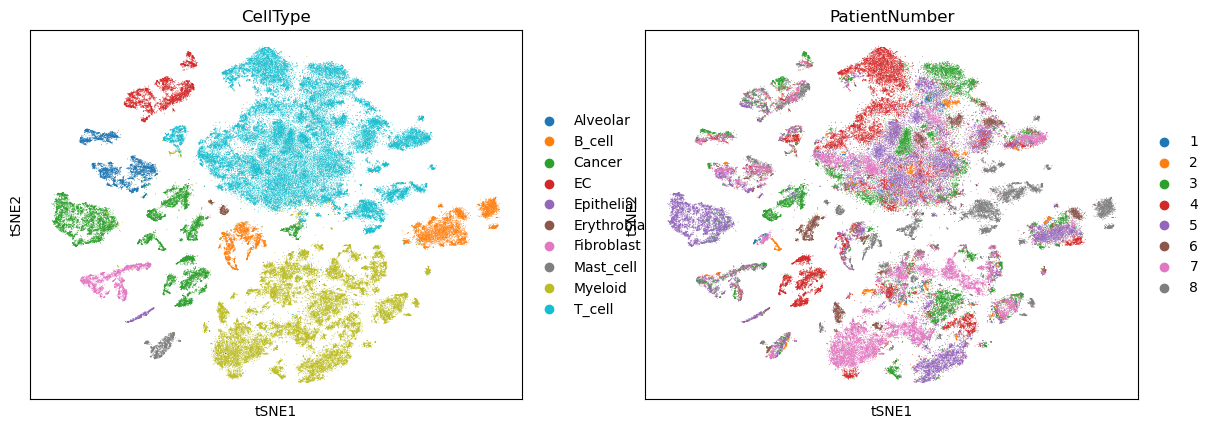

In [44]:
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [45]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

[W] [16:04:51.519199] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
CPU times: user 1.85 s, sys: 926 ms, total: 2.78 s
Wall time: 2.8 s


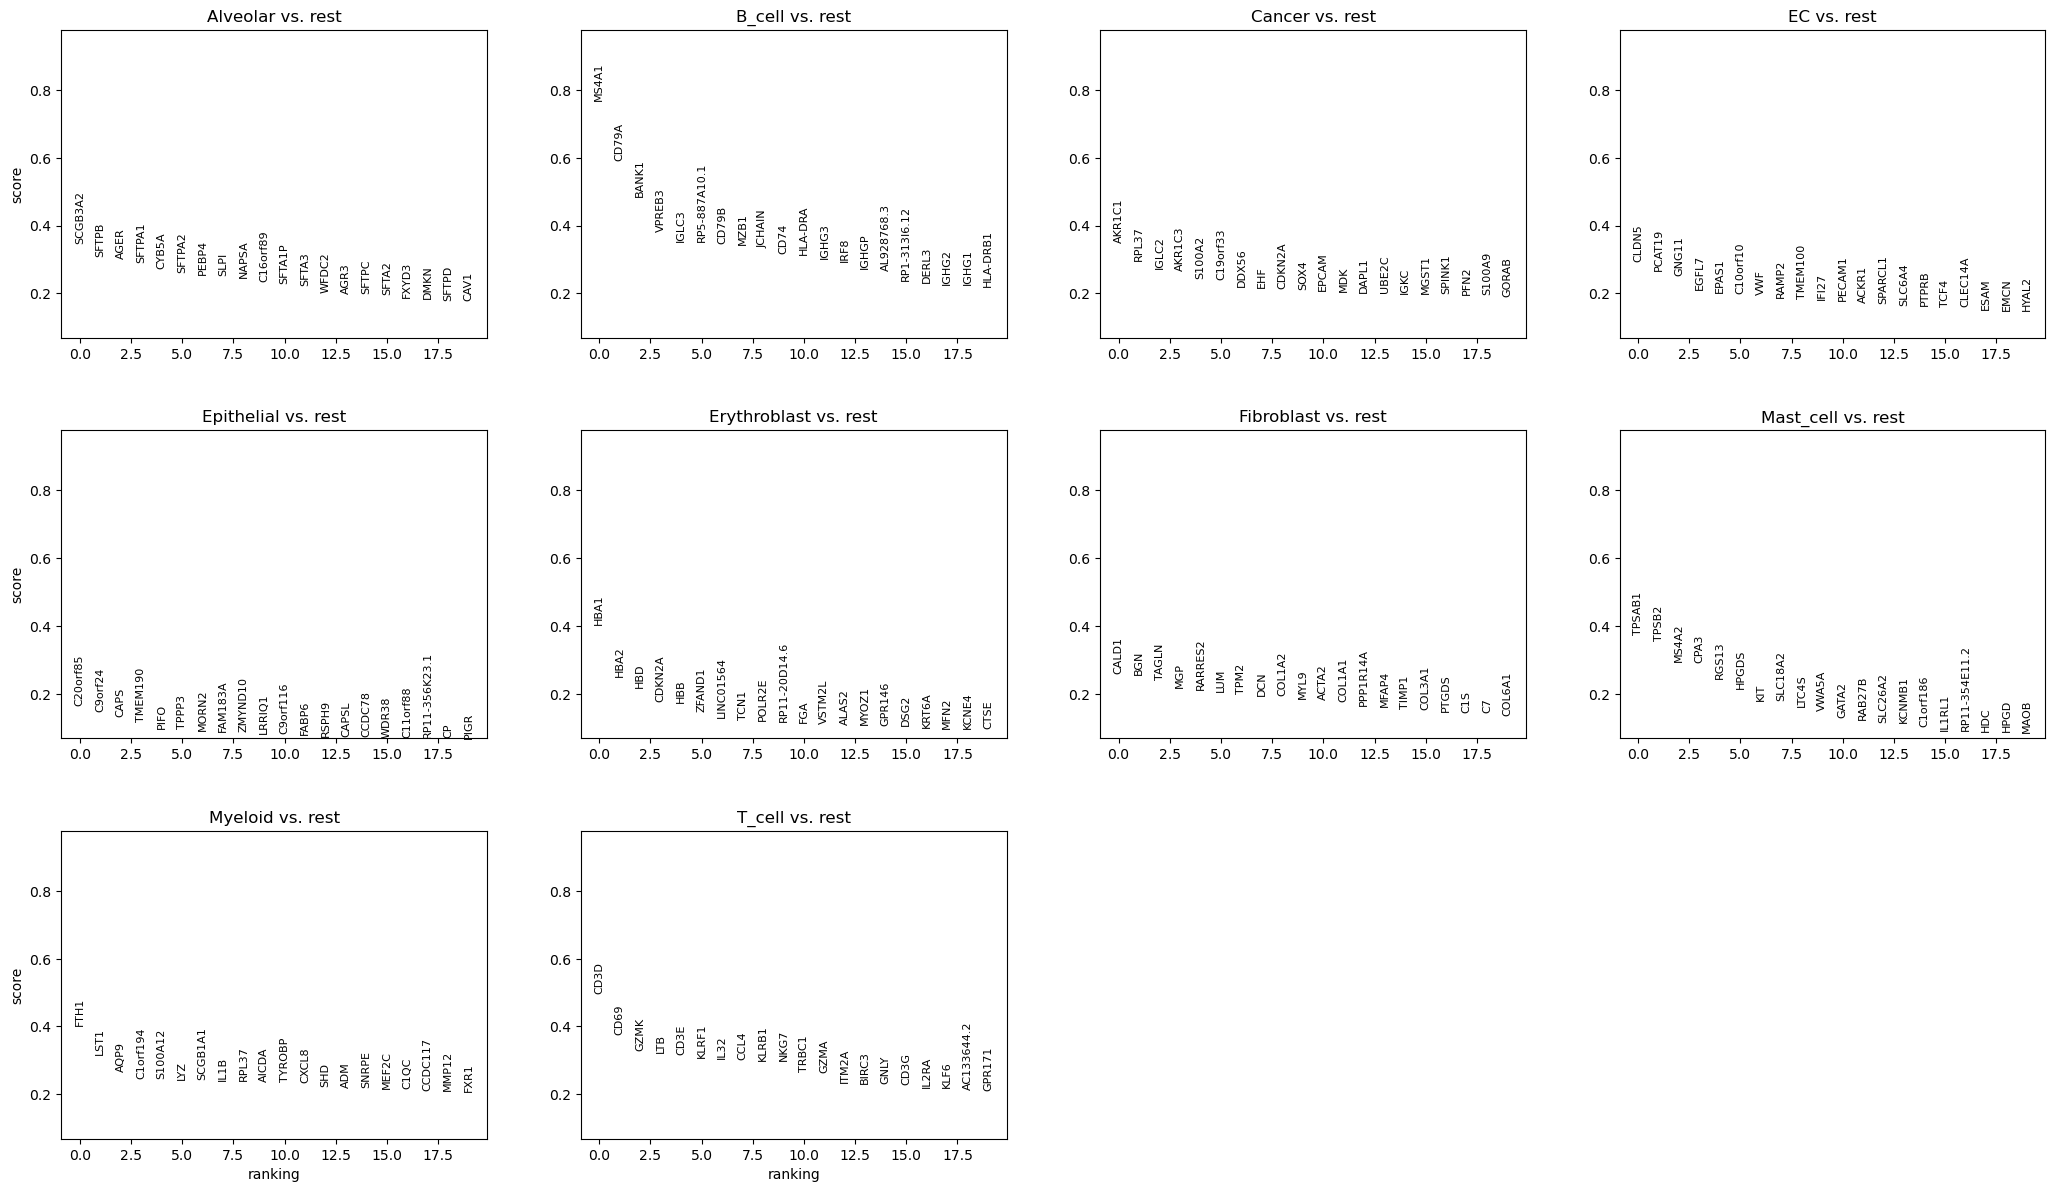

CPU times: user 972 ms, sys: 177 ms, total: 1.15 s
Wall time: 964 ms


In [46]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [47]:
post_time = time.time()

In [48]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 37.474546670913696


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [49]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:].copy()

We can repeat the dimension reduction, clustering and visulatization.

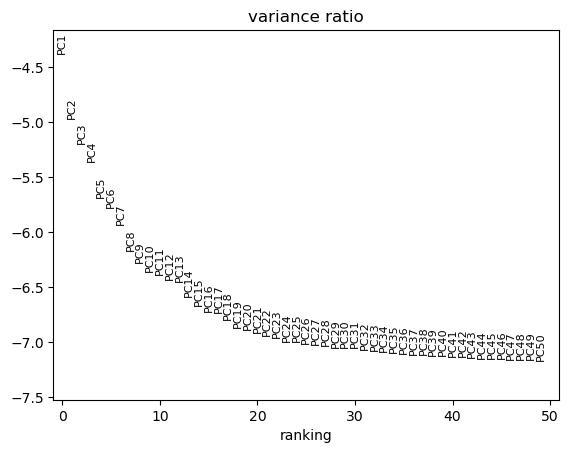

CPU times: user 989 ms, sys: 498 ms, total: 1.49 s
Wall time: 1.31 s


In [50]:
%%time
rsc.tl.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [51]:
%%time
rsc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
rsc.tl.umap(tdata)
rsc.tl.louvain(tdata)

CPU times: user 362 ms, sys: 195 ms, total: 558 ms
Wall time: 558 ms


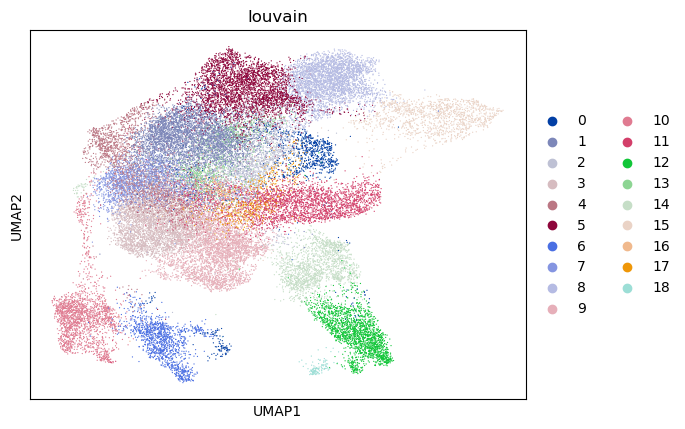

In [52]:
sc.pl.umap(tdata, color=["louvain"])

As stated before Diffusion Maps have become an integral part of single cell analysis.

In [53]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 492 ms, sys: 1.74 s, total: 2.23 s
Wall time: 224 ms


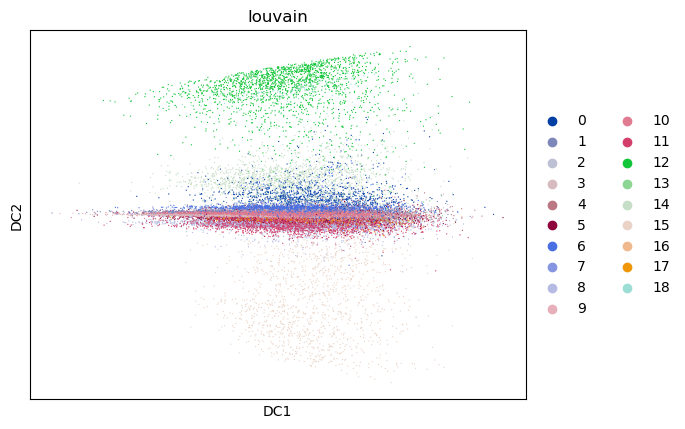

In [54]:
sc.pl.diffmap(tdata, color='louvain')

In [55]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 338 ms, sys: 11.2 ms, total: 350 ms
Wall time: 349 ms


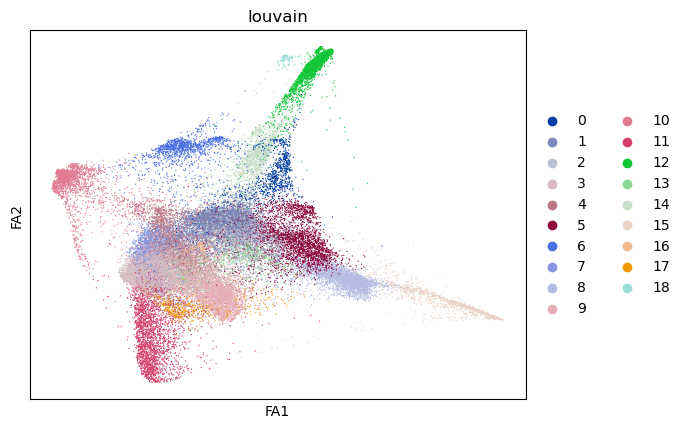

In [56]:
sc.pl.draw_graph(tdata, color='louvain')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [57]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 48.78057503700256
